In [411]:
library(tensorflow)
library(keras)
library(tidyverse)
library(keras)
library(tensorflow)
library(zoo)
library(dplyr)
library(ggplot2)
library(sp)
library(sf)
# Load necessary libraries
library(dplyr)
library(tidyr)
library(ggplot2)
library(sf)
library(caret)
library(lubridate)

In [ ]:
# Load the dataset
df <- readRDS("/kaggle/input/dataset-malaria/Mozambique data_tutorial_STUDENTS_revised.rds")
analysis_data <- df$analysis_data %>% ungroup()

# Convert SpatialPolygonsDataFrame to sf (only if needed)
moz_shapefile_sf <- st_as_sf(df$moz_shapefile)  

# Compute centroids for each district
centroids_sf <- st_centroid(moz_shapefile_sf)

# Extract the centroid coordinates (longitude and latitude)
centroids_coordinates <- st_coordinates(centroids_sf)

# Add longitude and latitude to the shapefile
moz_shapefile_sf <- moz_shapefile_sf %>%
  mutate(
    longitude = centroids_coordinates[, 1], 
    latitude = centroids_coordinates[, 2]
  )

# Check if longitude & latitude were added correctly
head(moz_shapefile_sf)


In [490]:
# Load the dataset
df <- readRDS("/kaggle/input/dataset-malaria/Mozambique data_tutorial_STUDENTS_revised.rds")
analysis_data <- df$analysis_data %>% ungroup()
# Inspect the structure of the dataset
#str(df$analysis_data)
#colnames(df$analysis_data)

# Convert SpatialPolygonsDataFrame to sf
moz_shapefile_sf <- st_as_sf(df$moz_shapefile)
head(moz_shapefile_sf)

,ADM1_PT,ADM2_PT,ADM2_PCODE,district,geometry
,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>
0,Zambezia,Alto Molocue,MZ1101,alto molocue,MULTIPOLYGON (((37.37028 -1...
1,Cabo Delgado,Ancuabe,MZ0101,ancuabe,MULTIPOLYGON (((40.12666 -1...
2,Nampula,Angoche,MZ0701,angoche,MULTIPOLYGON (((39.881 -16....
3,Tete,Angonia,MZ1001,angonia,MULTIPOLYGON (((34.3595 -14...
4,Cabo Delgado,Balama,MZ0102,balama,MULTIPOLYGON (((38.55654 -1...
5,Manica,Barue,MZ0401,barue,MULTIPOLYGON (((33.11776 -1...


In [491]:
colSums(is.na(df$analysis_data))

district 
                                                        0 
                                                     year 
                                                        0 
                                                    month 
                                                        0 
                                             district_SPH 
                                                      790 
                                         malaria_cases_u5 
                                                      636 
                                           diarr_cases_u5 
                                                      636 
                                               population 
                                                        0 
                                                     tmin 
                                                       36 
                                                     tmax 
                                                       36 
                                                       RH 
                                                        0 
                                            precipitation 
                                                        0 
                                                     ndvi 
                                                       68 
                                                  ADM1_PT 
                                                        0 
                                                  ADM2_PT 
                                                        0 
                                               ADM2_PCODE 
                                                        0 
                                                       ID 
                                                        0 
                                                prop_poor 
                                                        0 
                            prop_Number_of_children_3plus 
                                                        0 
                                               prop_Rural 
                                                        0 
                               prop_drinking_TreatedWater 
                                                        0 
                           prop_Time_get_Water60_plus_min 
                                                        0 
                                           prop_No_Toilet 
                                                        0 
                                     prop_Has_Electricity 
                                                        0 
                                           prop_Has_Radio 
                                                        0 
                              prop_floor_Material_natural 
                                                        0 
                                prop_Sleeping_Rooms_3plus 
                                                        0 
                                        prop_share_Toilet 
                                                        0 
                           prop_Has_sleeping_mosquito_net 
                                                        0 
     prop_some_or_all_children_slept_under_net_last_night 
                                                        0 
                      prop_house_holds_share_toilet_9Plus 
                                                        0 
                                     prop_Has_mobilephone 
                                                        0 
                     prop_dwelling_sprayed_last_12_Months 
                                                        0 
                            prop_with_3Plus_mosquito_nets 
                                                        0 
prop_children_under_mosquito_bed_nets_previous_night2Plus 
                                                        0 
                                     

In [492]:
data <- analysis_data %>%
  select(
    district, year, month, malaria_cases_u5, tmin, tmax, precipitation, RH, population,
    ndvi, prop_poor, prop_Rural, prop_drinking_TreatedWater, prop_Has_sleeping_mosquito_net,
    prop_dwelling_sprayed_last_12_Months, prop_uneducated, number_of_doctors, diarr_cases_u5
  ) 
head(data)


district,year,month,malaria_cases_u5,tmin,tmax,precipitation,RH,population,ndvi,prop_poor,prop_Rural,prop_drinking_TreatedWater,prop_Has_sleeping_mosquito_net,prop_dwelling_sprayed_last_12_Months,prop_uneducated,number_of_doctors,diarr_cases_u5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
alto molocue,2016,1,5361,21.29408,30.05298,316.3122584,84.78125,398318,0.2497222,30.82,77.98,17.64,85.55,1.76,13.33,2433,361
alto molocue,2016,2,4417,21.27051,29.67830,129.9722557,87.45982,398318,0.3239641,30.82,77.98,17.64,85.55,1.76,13.33,2433,213
alto molocue,2016,3,5778,22.02337,29.52276,354.2848948,89.66429,398318,0.3125448,30.82,77.98,17.64,85.55,1.76,13.33,2433,193
alto molocue,2016,4,3573,19.59610,26.56818,85.3606402,90.84375,398318,0.2893758,30.82,77.98,17.64,85.55,1.76,13.33,2433,92
alto molocue,2016,5,3306,16.40217,25.48012,0.8187776,85.98214,398318,0.2982987,30.82,77.98,17.64,85.55,1.76,13.33,2433,124
alto molocue,2016,6,4059,14.23255,24.10960,2.4701347,79.62500,398318,0.3183219,30.82,77.98,17.64,85.55,1.76,13.33,2433,188


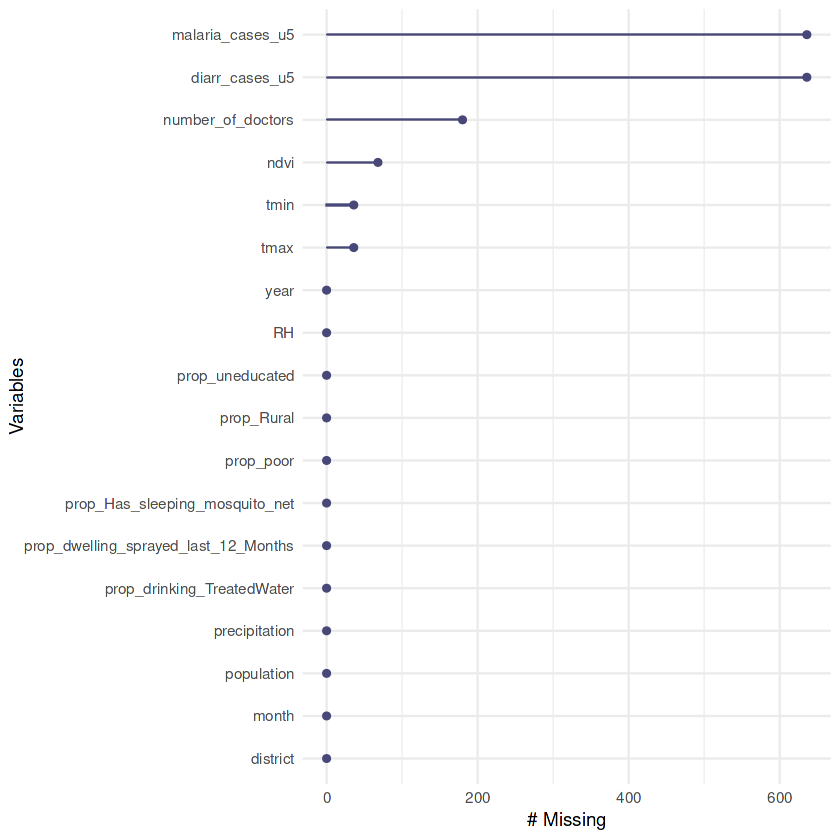

In [493]:
library(naniar)
library(ggplot2)

# Plot missing values
plot <- gg_miss_var(data)

# Display the plot
print(plot)

# Save the plot to a PDF file
ggsave("missing_values_plot.pdf", plot = plot, width = 10, height = 6)


Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”


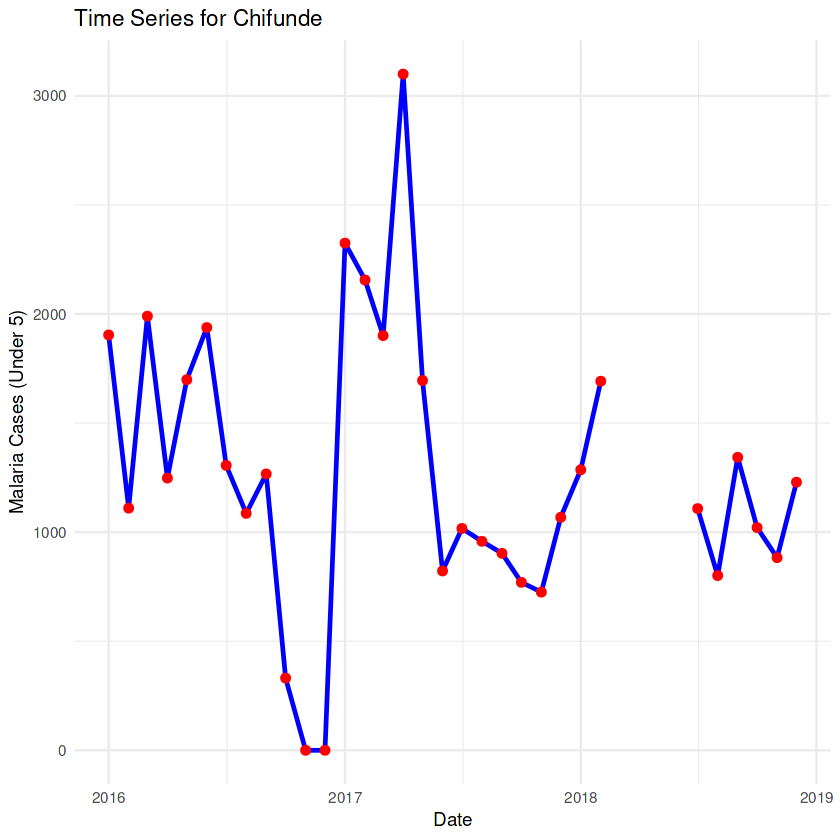

In [494]:
# Filter for the district "chifunde"
district_data <- analysis_data %>%
  filter(district == "chifunde")

# Add a date column
district_data <- district_data %>%
  mutate(date = make_date(year, month, 1))

# Plot the time series for "chifunde"
plot <- ggplot(district_data, aes(x = date, y = malaria_cases_u5)) +
  geom_line(color = "blue", size = 1) +
  geom_point(color = "red", size = 2) +
  theme_minimal() +
  labs(title = "Time Series for Chifunde", x = "Date", y = "Malaria Cases (Under 5)")

# Display the plot
print(plot)

# Save the plot to a PDF file
ggsave("time_series_chifunde.pdf", plot = plot, width = 10, height = 6)


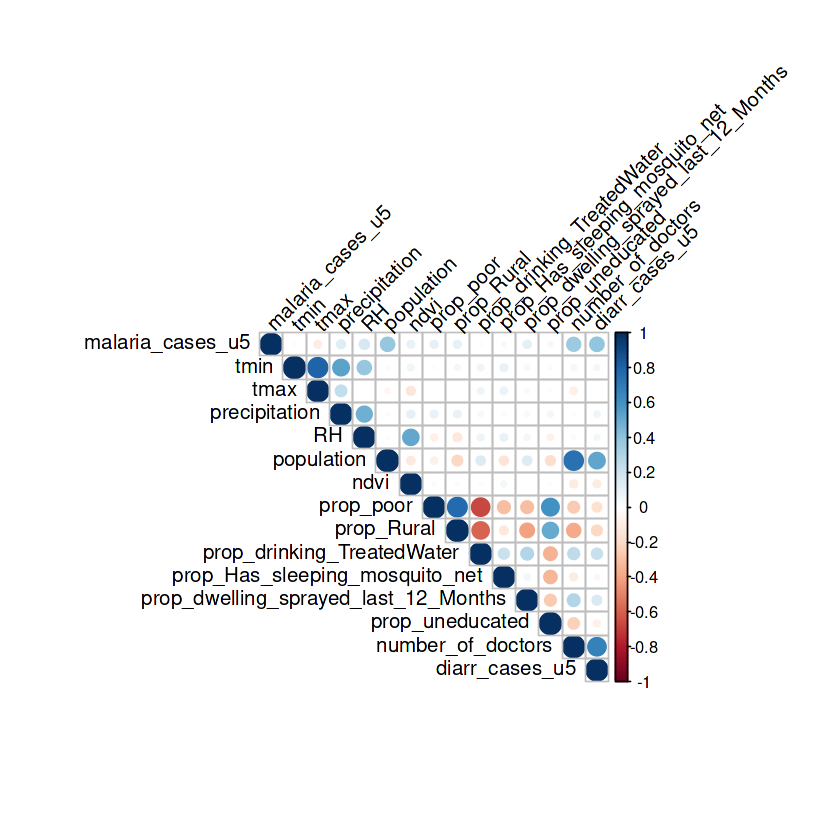

In [495]:
library(corrplot)
numeric_vars <- data %>%
  select(where(is.numeric)) %>%
  select(-year, -month)  # Exclude year and month for correlation analysis
 
cor_matrix <- cor(numeric_vars, use = "complete.obs")

# Visualize correlations
corrplot(cor_matrix, method = "circle", type = "upper", tl.col = "black", tl.srt = 45)

In [419]:
# # Create lagged variables for tmin, tmax, RH
# data <- data %>%
#   group_by(district) %>%
#   arrange(year, month) %>%
#   mutate(
#     lag_RH_1 = lag(RH, 1),    
#     lag_RH_2 = lag(RH, 2)   
#   )


In [496]:
dataset <- data %>%
  filter(year < 2018 | (year == 2018 & (month <= 2 | month >= 7)))


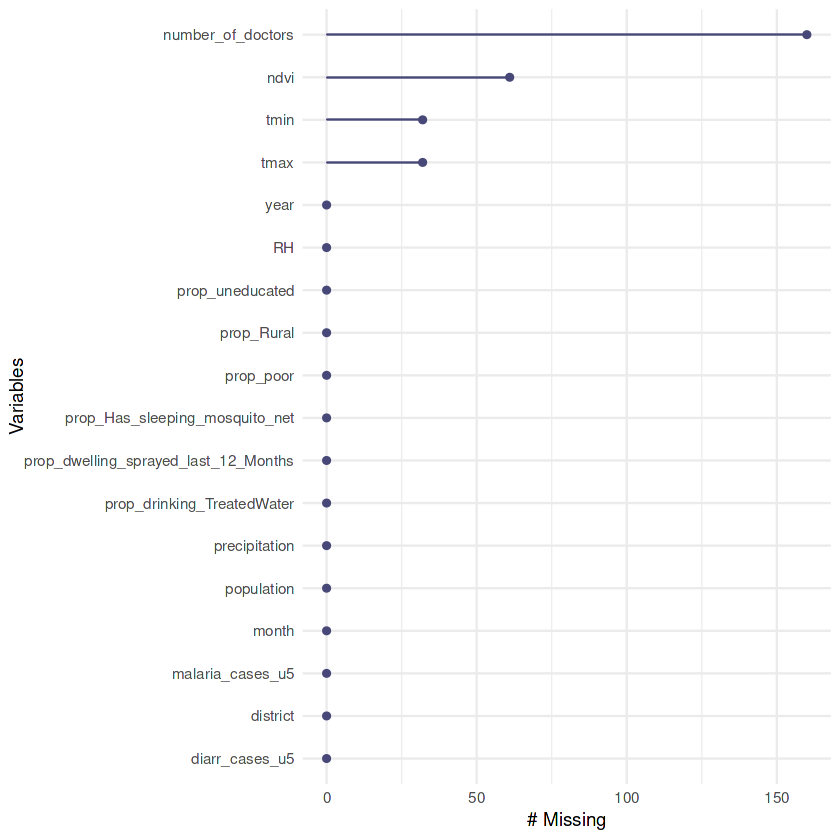

In [497]:
library(naniar)
library(ggplot2)

# Plot missing values
plot <- gg_miss_var(dataset)

# Display the plot
print(plot)

# Save the plot to a PDF file
ggsave("missing_values_plot.pdf", plot = plot, width = 10, height = 6)


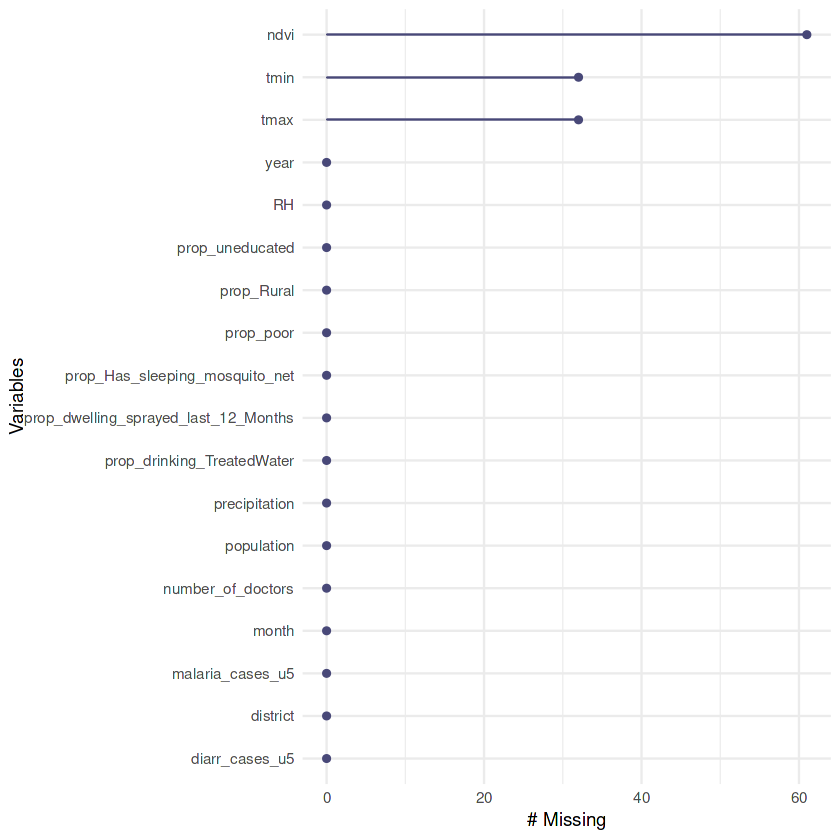

In [498]:
impute_mean <- function(data, variable) {
  # Calculate district-level means
  district_means <- data %>%
    group_by(district) %>%
    summarise(district_mean = mean(.data[[variable]], na.rm = TRUE)) %>%
    ungroup()
  
  # Calculate global mean
  global_mean <- mean(data[[variable]], na.rm = TRUE)
  
  # Impute missing values
  data <- data %>%
    left_join(district_means, by = "district") %>%
    mutate(!!variable := ifelse(
      is.na(.data[[variable]]),
      ifelse(is.na(district_mean), global_mean, district_mean),
      .data[[variable]]
    )) %>%
    select(-district_mean)
  
  return(data)
}

# Impute missing values for each variable
dataset <- dataset %>%
  impute_mean("number_of_doctors") 
# Plot missing values
library(naniar)
plot <- gg_miss_var(dataset)

# Display the plot
print(plot)

In [499]:
library(missForest)
imputation_data <- dataset
imputation_data$district <- NULL

# Apply missForest for imputation
set.seed(123) 
imputed_result <- missForest(as.data.frame(imputation_data), 
                             ntree = 500,  
                             maxiter = 100) 

# Replace the imputed columns in the original data
dataset[ , names(imputation_data)] <- imputed_result$ximp

# Check for remaining missing values
colSums(is.na(dataset))


district                                 year 
                                   0                                    0 
                               month                     malaria_cases_u5 
                                   0                                    0 
                                tmin                                 tmax 
                                   0                                    0 
                       precipitation                                   RH 
                                   0                                    0 
                          population                                 ndvi 
                                   0                                    0 
                           prop_poor                           prop_Rural 
                                   0                                    0 
          prop_drinking_TreatedWater       prop_Has_sleeping_mosquito_net 
                                   0                                    0 
prop_dwelling_sprayed_last_12_Months                      prop_uneducated 
                                   0                                    0 
                   number_of_doctors                       diarr_cases_u5 
                                   0                                    0

In [500]:
write.csv(dataset, "imputed_data.csv", row.names = FALSE)
saveRDS(dataset, "imputed_data.rds")

In [425]:
# dataset

In [521]:
data_train<-readRDS("imputed_data.rds")

In [522]:
data_train

district,year,month,malaria_cases_u5,tmin,tmax,precipitation,RH,population,ndvi,prop_poor,prop_Rural,prop_drinking_TreatedWater,prop_Has_sleeping_mosquito_net,prop_dwelling_sprayed_last_12_Months,prop_uneducated,number_of_doctors,diarr_cases_u5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
alto molocue,2016,1,5361,21.29408,30.05298,316.3122584,84.78125,398318.0,0.2497222,30.82,77.98,17.64,85.55,1.76,13.33,2433,361
alto molocue,2016,2,4417,21.27051,29.67830,129.9722557,87.45982,398318.0,0.3239641,30.82,77.98,17.64,85.55,1.76,13.33,2433,213
alto molocue,2016,3,5778,22.02337,29.52276,354.2848948,89.66429,398318.0,0.3125448,30.82,77.98,17.64,85.55,1.76,13.33,2433,193
alto molocue,2016,4,3573,19.59610,26.56818,85.3606402,90.84375,398318.0,0.2893758,30.82,77.98,17.64,85.55,1.76,13.33,2433,92
alto molocue,2016,5,3306,16.40217,25.48012,0.8187776,85.98214,398318.0,0.2982987,30.82,77.98,17.64,85.55,1.76,13.33,2433,124
alto molocue,2016,6,4059,14.23255,24.10960,2.4701347,79.62500,398318.0,0.3183219,30.82,77.98,17.64,85.55,1.76,13.33,2433,188
alto molocue,2016,7,3018,14.14210,24.67967,1.1800000,75.30357,398318.0,0.2385558,30.82,77.98,17.64,85.55,1.76,13.33,2433,189
alto molocue,2016,8,2066,13.98268,25.92700,0.0000000,68.08482,398318.0,0.2197919,30.82,77.98,17.64,85.55,1.76,13.33,2433,146
alto molocue,2016,9,4296,16.37980,28.86274,0.0000000,60.32143,398318.0,0.1770205,30.82,77.98,17.64,85.55,1.76,13.33,2433,227


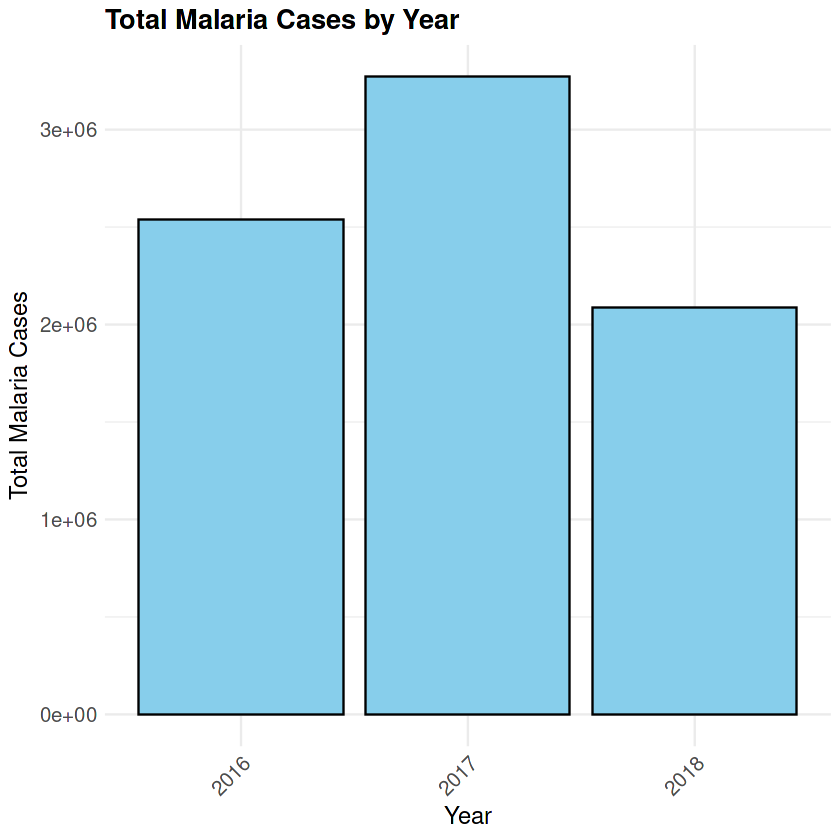

In [523]:
library(ggplot2)
library(dplyr)

# Summarize the data by year
df_summary <- data_train %>%
  group_by(year) %>%
  summarize(total_malaria_cases = sum(malaria_cases_u5))

# Plot the data
ggplot(df_summary, aes(x = factor(year), y = total_malaria_cases)) +
  geom_bar(stat = "identity", fill = "skyblue", color = "black") +
  labs(
    title = "Total Malaria Cases by Year",
    x = "Year",
    y = "Total Malaria Cases"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14)
  )


In [612]:
# # Load necessary library
# library(dplyr)

# # Remove rows where malaria_cases_u5 is equal to 0
# # data_train <- data_train %>% filter(malaria_cases_u5 != 0)
# # validation_data2 <- validation_data %>% filter(malaria_cases_u5 != 0)

# data1<-data_train
# data1$district<-NULL
# # data1$year<-NULL
# # data1$month<-NULL
# # Function to scale data to the range [0, 1]
# min_max_scale <- function(x) {
#   return((x - min(x)) / (max(x) - min(x)))
# }

# # # Apply scaling to the entire dataset (assuming it's numeric)
# scaled_data <- as.data.frame(lapply(data1, min_max_scale))

In [613]:
data1 <- data_train
data1$district <- NULL
# Optional: Remove year, month, or other non-numeric columns if needed
# data1$year <- NULL
# data1$month <- NULL

# Columns to exclude from scaling
exclude_columns <- c("malaria_cases_u5", "diarr_cases_u5")

# Function to scale data to the range [0, 1] for selected columns
min_max_scale <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}

# Apply scaling to the entire dataset except for the excluded columns
scaled_data <- data1 %>%
  select(-all_of(exclude_columns)) %>%
  lapply(min_max_scale) %>%
  as.data.frame()

# Reattach the unscaled columns (malaria_cases_u5, diarr_cases_u5)
scaled_data <- cbind(scaled_data, data1[exclude_columns])
head(scaled_data)

,year,month,tmin,tmax,precipitation,RH,population,ndvi,prop_poor,prop_Rural,prop_drinking_TreatedWater,prop_Has_sleeping_mosquito_net,prop_dwelling_sprayed_last_12_Months,prop_uneducated,number_of_doctors,malaria_cases_u5,diarr_cases_u5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0.00000000,0.7584631,0.6291789,0.617139878,0.8454817,0.3278049,0.4755364,0.3196101,0.6774194,0.1764,0.7488267,0.02053436,0.1444047,0.2916965,5361,361
2,0,0.09090909,0.7570760,0.6105771,0.253581895,0.8876959,0.3278049,0.6322468,0.3196101,0.6774194,0.1764,0.7488267,0.02053436,0.1444047,0.2916965,4417,213
3,0,0.18181818,0.8013830,0.6028552,0.691226252,0.9224383,0.3278049,0.6081429,0.3196101,0.6774194,0.1764,0.7488267,0.02053436,0.1444047,0.2916965,5778,193
4,0,0.27272727,0.6585343,0.4561693,0.166542566,0.9410267,0.3278049,0.5592376,0.3196101,0.6774194,0.1764,0.7488267,0.02053436,0.1444047,0.2916965,3573,92
5,0,0.36363636,0.4705663,0.4021506,0.001597473,0.8644077,0.3278049,0.5780721,0.3196101,0.6774194,0.1764,0.7488267,0.02053436,0.1444047,0.2916965,3306,124
6,0,0.45454545,0.3428810,0.3341086,0.004819347,0.7642192,0.3278049,0.6203373,0.3196101,0.6774194,0.1764,0.7488267,0.02053436,0.1444047,0.2916965,4059,188


In [614]:
# # # Split data
# train_data <- data1 %>%
#   filter(year < 2018 | (year == 2018 & month < 3))

# validation_data <- data1 %>%
#   filter(year == 2018 & month >= 7)
# # # train_data <- data %>%
# # #   filter(year < 2018)

# # # validation_data <- data %>%
# # #   filter(year == 2017)
# #test_data <- df$analysis_data %>%
# #    filter(year == 2018 & month >= 3 & month <= 6)
# min_max_scale <- function(x) {
#   return((x - min(x)) / (max(x) - min(x)))
# }

# # # Apply scaling to the entire dataset (assuming it's numeric)
# train_data <- as.data.frame(lapply(train_data, min_max_scale))
# validation_data <- as.data.frame(lapply(validation_data, min_max_scale))

In [615]:

# set.seed(123)
n <- nrow(scaled_data)


train_indices <- sample(1:n, size = floor(0.8 * n))
# data_train1<-data_train %>%group_by(district)
train_data <- scaled_data[train_indices, ]
validation_data <- scaled_data[-train_indices, ]
nrow(validation_data)

[1] 1018

In [616]:
# validation_data

**Linear Regression**

In [617]:
train_data$year<-NULL
validation_data$year<-NULL
train_data$month<-NULL
validation_data$month<-NULL
train_data<- train_data %>% filter(malaria_cases_u5 != 0)
validation_data <- validation_data %>% filter(malaria_cases_u5 != 0)

In [619]:
# Load necessary library
library(dplyr)

# Linear Regression model using glm
lm_model <- glm(malaria_cases_u5 ~ ., data = train_data %>% select(-diarr_cases_u5))

# Evaluate on validation data
lm_pred <- predict(lm_model, newdata = validation_data)

# Function for inverse scaling
inverse_transform <- function(scaled, original) {
  return(scaled * (max(original) - min(original)) + min(original))
}

# Apply inverse transform to the predictions and validation data
# lm_pred <- inverse_transform(lm_pred, data_train$malaria_cases_u5)
val <- validation_data$malaria_cases_u5
# val <- inverse_transform(val, data_train$malaria_cases_u5)

# RMSE Calculation
lm_mse <- mean((val - lm_pred)^2)
lm_rmse <- sqrt(lm_mse)
print(paste("Linear Regression RMSE:", lm_rmse))

# Create a dataframe with actual vs predicted values and the difference
results_df_lm <- data.frame(
  Actual = val,
  Predicted = lm_pred,
  Difference = val - lm_pred
)

# View the first few rows of results
head(results_df_lm)


[1] "Linear Regression RMSE: 1553.94757803777"


,Actual,Predicted,Difference
,<dbl>,<dbl>,<dbl>
1,3018,3015.742,2.257666
2,3872,3014.581,857.419431
3,3628,2512.503,1115.497169
4,3893,1796.321,2096.679347
5,2304,1382.841,921.158923
6,2672,2000.457,671.542790


**randomForest**

In [620]:
# Random forest model
library(randomForest)


In [621]:
rf_model <- randomForest(
  malaria_cases_u5 ~ ., 
  data = train_data %>% select(-diarr_cases_u5), 
  ntree = 150,        
  mtry = floor(sqrt(ncol(train_data) - 2)),  
  nodesize = 10,      
  importance = TRUE,  
  do.trace = 100      
)

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 100 | 6.569e+05    19.34 |


In [644]:
# Evaluate on validation data
rf_pred <- predict(rf_model, newdata = validation_data)
# Inverse transform the SVR predictions to original scale
# rf_pred <- inverse_transform(rf_pred, data_train$malaria_cases_u5)
val<-validation_data$malaria_cases_u5 
# val<-inverse_transform(val, data_train$malaria_cases_u5)
rf_mse <- mean((val - rf_pred)^2)
rf_rmse<-sqrt(rf_mse)
print(paste("Random Forest RMSE:", rf_rmse))

# Create a dataframe with actual and predicted values
results_df_rf <- data.frame(
  Actual = val,
  Predicted = rf_pred,
  Difference = val - rf_pred
)

# View the dataframe with actual, predicted values and the difference
head(results_df_rf)


[1] "Random Forest RMSE: 775.54952761909"


,Actual,Predicted,Difference
,<dbl>,<dbl>,<dbl>
1,3018,3655.036,-637.0362
2,3872,3545.130,326.8702
3,3628,3763.909,-135.9087
4,3893,2628.312,1264.6877
5,2304,2444.045,-140.0447
6,2672,2501.106,170.8945


**XGBoost**

In [669]:
# Load required libraries
library(xgboost)
library(dplyr)

# Ensure validation data has the same features as training
# common_features <- setdiff(names(train_data), "malaria_cases_u5")

# Convert to XGBoost DMatrix
train_matrix <- xgb.DMatrix(
  data = as.matrix(train_data %>% select(-malaria_cases_u5,-diarr_cases_u5)), 
  label = train_data$malaria_cases_u5
)
validation_matrix <- xgb.DMatrix(
  data = as.matrix(validation_data %>% select(-malaria_cases_u5,-diarr_cases_u5)),
    label=validation_data$malaria_cases_u5
)

# Define XGBoost parameters
xgb_params <- list(
  objective = "reg:squarederror",  # Regression task
  eval_metric = "rmse",            # Root Mean Squared Error
  eta = 0.09,                      # Learning rate (smaller to stabilize training)
  max_depth =25,                    # Tree depth for complexity
  subsample = 0.8,                 # Prevents overfitting
  colsample_bytree = 0.5,          # Feature sampling
  lambda = 1,                      # L2 regularization (Ridge)
  alpha = 0.01 
  
    

)

# Train XGBoost model with early stopping
xgb_model <- xgb.train(
  params = xgb_params,
  data = train_matrix,
  nrounds = 200,  # Boosting rounds
  early_stopping_rounds = 20,
  watchlist = list(train = train_matrix),
  verbose = 0
)
print(xgb_model)
# Predict on validation data
xgb_predictions <- predict(xgb_model, newdata = validation_matrix)

# # Inverse Scaling (corrected version)
# inverse_transform <- function(scaled, original) {
#   return(scaled * (max(original) - min(original)) + min(original))
# }

# Apply inverse transform using the correct scale
# xgb_predictions <- inverse_transform(xgb_predictions, data_train$malaria_cases_u5)
# val <- inverse_transform(validation_data$malaria_cases_u5, data_train$malaria_cases_u5)  # Corrected

# RMSE Calculation
xgb_mse <- mean((val - xgb_predictions)^2)
xgb_rmse <- sqrt(xgb_mse)
print(paste("XGBoost RMSE:", xgb_rmse))

# Create dataframe with actual vs predicted values
results_df_xgb <- data.frame(
  Actual = val,
  Predicted = xgb_predictions,
  Difference = val - xgb_predictions
)

xgb.save(xgb_model, "xgb_model.model")

# Display first few rows
results_df_xgb


##### xgb.Booster
raw: 18.1 Mb 
call:
  xgb.train(params = xgb_params, data = train_matrix, nrounds = 200, 
    watchlist = list(train = train_matrix), verbose = 0, early_stopping_rounds = 20)
params (as set within xgb.train):
  objective = "reg:squarederror", eval_metric = "rmse", eta = "0.09", max_depth = "25", subsample = "0.8", colsample_bytree = "0.5", lambda = "1", alpha = "0.01", validate_parameters = "TRUE"
xgb.attributes:
  best_iteration, best_msg, best_ntreelimit, best_score, niter
callbacks:
  cb.evaluation.log()
  cb.early.stop(stopping_rounds = early_stopping_rounds, maximize = maximize, 
    verbose = verbose)
# of features: 13 
niter: 200
best_iteration : 200 
best_ntreelimit : 200 
best_score : 0.5274604 
best_msg : [200]	train-rmse:0.527460 
nfeatures : 13 
evaluation_log:
     iter   train_rmse
    <num>        <num>
        1 2398.0340563
        2 2220.6394568
---                   
      199    0.5464078
      200    0.5274604
[1] "XGBoost RMSE: 777.282337817061"


[1] TRUE

Actual,Predicted,Difference
<dbl>,<dbl>,<dbl>
3018,3379.266,-361.26636
3872,3318.850,553.15039
3628,3658.595,-30.59521
3893,2264.781,1628.21875
2304,2457.348,-153.34814
2672,2491.178,180.82178
2508,2255.955,252.04517
1188,1472.122,-284.12158
959,1299.130,-340.13049


ERROR: Error in UseMethod("grid.draw"): no applicable method for 'grid.draw' applied to an object of class "c('data.table', 'data.frame')"


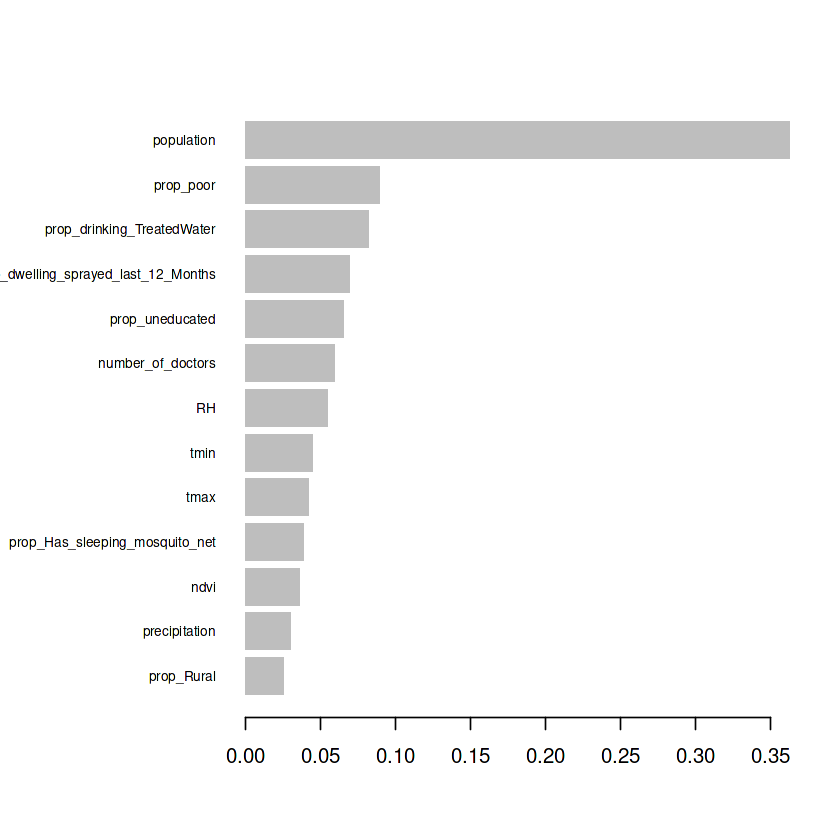

In [674]:
library(ggplot2)

# Generate and save the feature importance plot
importance_matrix <- xgb.importance(model = xgb_model)
p <- xgb.plot.importance(importance_matrix)
# Save the plot as an image
ggsave("xgb_feature_importance.png", plot = p, width = 8, height = 6, dpi = 300)


In [705]:
# Load required libraries
library(xgboost)
library(dplyr)

# Convert to XGBoost DMatrix for Diarrheal Cases
train_matrix_diarr <- xgb.DMatrix(
  data = as.matrix(train_data %>% select(-malaria_cases_u5, -diarr_cases_u5)), 
  label = train_data$diarr_cases_u5
)
validation_matrix_diarr <- xgb.DMatrix(
  data = as.matrix(validation_data %>% select(-malaria_cases_u5, -diarr_cases_u5))
)

# Define XGBoost parameters (same as malaria, but can be tuned separately)
xgb_params <- list(
  objective = "reg:squarederror",  # Regression task
  eval_metric = "rmse",            # Root Mean Squared Error
  eta = 0.09,                      # Learning rate
  max_depth =25 ,                  # Tree depth
  subsample = 0.8,                 
  colsample_bytree = 0.5,          
  lambda = 1,                      
  alpha = 0.05
)

# Train XGBoost model
xgb_model_diarr <- xgb.train(
  params = xgb_params,
  data = train_matrix_diarr,
  nrounds = 150,  
  early_stopping_rounds = 20,
  watchlist = list(train = train_matrix_diarr),
  verbose = 0
)
print(xgb_model_diarr)

# Predict on validation data
diarr_predictions <- predict(xgb_model_diarr, newdata = validation_matrix_diarr)

# Save model
xgb.save(xgb_model_diarr, "xgb_model_diarr.model")

# RMSE Calculation (if true values exist)
val_diarr <- validation_data$diarr_cases_u5
xgb_mse_diarr <- mean((val_diarr - diarr_predictions)^2)
xgb_rmse_diarr <- sqrt(xgb_mse_diarr)
print(paste("XGBoost RMSE for Diarrheal Cases:", xgb_rmse_diarr))

# Create dataframe with actual vs predicted values for diarrheal cases
results_df_diarr <- data.frame(
  Actual = val_diarr,
  Predicted = diarr_predictions,
  Difference = val_diarr - diarr_predictions
)


# Display first few rows of the results
results_df_diarr


##### xgb.Booster
raw: 11.7 Mb 
call:
  xgb.train(params = xgb_params, data = train_matrix_diarr, nrounds = 150, 
    watchlist = list(train = train_matrix_diarr), verbose = 0, 
    early_stopping_rounds = 20)
params (as set within xgb.train):
  objective = "reg:squarederror", eval_metric = "rmse", eta = "0.09", max_depth = "25", subsample = "0.8", colsample_bytree = "0.5", lambda = "1", alpha = "0.05", validate_parameters = "TRUE"
xgb.attributes:
  best_iteration, best_msg, best_ntreelimit, best_score, niter
callbacks:
  cb.evaluation.log()
  cb.early.stop(stopping_rounds = early_stopping_rounds, maximize = maximize, 
    verbose = verbose)
# of features: 13 
niter: 150
best_iteration : 150 
best_ntreelimit : 150 
best_score : 0.5745844 
best_msg : [150]	train-rmse:0.574584 
nfeatures : 13 
evaluation_log:
     iter  train_rmse
    <num>       <num>
        1 325.1413304
        2 299.7777911
---                  
      149   0.5971734
      150   0.5745844


[1] TRUE

[1] "XGBoost RMSE for Diarrheal Cases: 92.0528420461311"


Actual,Predicted,Difference
<dbl>,<dbl>,<dbl>
189,155.86700,33.1329956
223,134.76532,88.2346802
187,166.65201,20.3479919
122,103.83096,18.1690445
71,93.47675,-22.4767456
129,122.50590,6.4941025
58,95.59588,-37.5958786
103,115.77389,-12.7738876
136,91.96786,44.0321426


In [ ]:
library(ggplot2)

# Generate and save the feature importance plot
importance_matrix <- xgb.importance(model = xgb_model)
p <- xgb.plot.importance(importance_matrix)
# Save the plot as an image
ggsave("xgb_feature_importance.png", plot = p, width = 8, height = 6, dpi = 300)


**SVR**

In [685]:
# Load required libraries
library(e1071)
library(dplyr)

# Train the SVR model with improved parameters
svr_model <- svm(
  malaria_cases_u5 ~ ., 
  data = train_data,
  kernel = "radial",           # Radial basis function kernel (can also try "linear" or "polynomial")
  cost = 200,                  # Regularization parameter (increase for stricter margin)
  gamma = 0.009,                # Kernel coefficient for radial basis kernel, lower value can help with overfitting
  epsilon = 0.01,              # Epsilon value for regression (controls the width of the margin)
               # Automatically scale features (use FALSE if data is already scaled)
  type = "eps-regression"     # Regression type (default)
)

# Predict on validation data
svr_predictions <- predict(svr_model, newdata = validation_data)

# Inverse Scaling Function
# inverse_transform <- function(scaled, original) {
#   return(scaled * (max(original) - min(original)) + min(original))
# }

# Apply inverse transform to predictions and actual values
# svr_predictions <- inverse_transform(svr_predictions, data_train$malaria_cases_u5)
# val <- inverse_transform(validation_data$malaria_cases_u5, data_train$malaria_cases_u5)

# Calculate RMSE
svr_mse <- mean((val - svr_predictions)^2)
svr_rmse <- sqrt(svr_mse)
print(paste("SVR RMSE:", svr_rmse))

# Create dataframe with actual vs predicted values
results_df_svr <- data.frame(
  Actual = val,
  Predicted = svr_predictions,
  Difference = val - svr_predictions
)

# Display first few rows
head(results_df_svr)


[1] "SVR RMSE: 875.348666208718"


,Actual,Predicted,Difference
,<dbl>,<dbl>,<dbl>
1,3018,4128.724,-1110.72423
2,3872,4349.422,-477.42169
3,3628,4300.624,-672.62373
4,3893,2513.081,1379.91910
5,2304,1947.468,356.53174
6,2672,2706.842,-34.84182


In [664]:
# Load necessary libraries
library(dplyr)
library(caret)
library(kknn)

# Prepare training and validation data (remove non-numeric features)
train_data_knn <- train_data %>% select(-malaria_cases_u5)
validation_data_knn <- validation_data %>% select(-malaria_cases_u5)

# Define tuning grid for kknn
tune_grid <- expand.grid(
  kmax = 4,       # Number of neighbors
  distance = 1,    # Euclidean distance (can try 2 for squared distance)
  kernel = "rect"  # Type of kernel (can try "rect", "gaussian", "epanechnikov")
)

# Train KNN model with corrected tuning grid
knn_model <- train(
  malaria_cases_u5 ~ ., 
  data = train_data, 
  method = "kknn",
  tuneGrid = tune_grid,  # Use the corrected grid
  trControl = trainControl(method = "cv", number = 5)  # Cross-validation
)

# Print model summary
print(knn_model)

# Predict on validation set
knn_predictions <- predict(knn_model, newdata = validation_data_knn)

# Inverse scaling
# inverse_transform <- function(scaled, original) {
#   return(scaled * (max(original) - min(original)) + min(original))
# }
val <- validation_data$malaria_cases_u5
saveRDS(knn_model, file = "knn_model.rds")
# Apply inverse transform
# knn_predictions <- inverse_transform(knn_predictions, data_train$malaria_cases_u5)
# val <- inverse_transform(validation_data$malaria_cases_u5, data_train$malaria_cases_u5)

# RMSE Calculation
knn_mse <- mean((val - knn_predictions)^2)
knn_rmse <- sqrt(knn_mse)
print(paste("KNN RMSE:", knn_rmse))

# Create dataframe with actual vs predicted values
results_df_knn <- data.frame(
  Actual = val,
  Predicted = knn_predictions,
  Difference = val - knn_predictions
)

# Display first few rows
results_df_knn


k-Nearest Neighbors 

3457 samples
  14 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2766, 2765, 2764, 2768, 2765 
Resampling results:

  RMSE      Rsquared   MAE     
  891.7857  0.7669948  536.7834

Tuning parameter 'kmax' was held constant at a value of 4
Tuning
 parameter 'distance' was held constant at a value of 1
Tuning
 parameter 'kernel' was held constant at a value of rect
[1] "KNN RMSE: 786.719183764496"


Actual,Predicted,Difference
<dbl>,<dbl>,<dbl>
3018,3653.25,-635.25
3872,3326.00,546.00
3628,4358.25,-730.25
3893,2949.00,944.00
2304,2840.50,-536.50
2672,2633.25,38.75
2508,2716.25,-208.25
1188,1925.25,-737.25
959,1925.25,-966.25


prediction on test

In [710]:
test_dataa<-df$analysis_data %>%
filter(year == 2018 & month >= 3 & month <= 6)

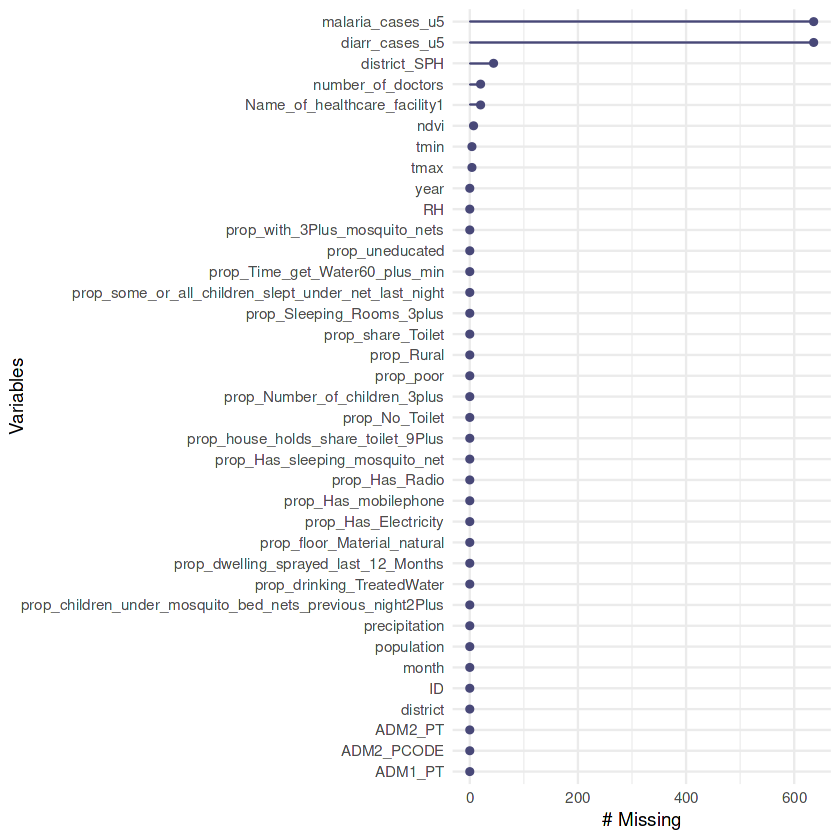

In [678]:
test_data<-analysis_data %>%
filter(year == 2018 & month >= 3 & month <= 6)
library(naniar)
plot <- gg_miss_var(test_data)

# Display the plot
print(plot)

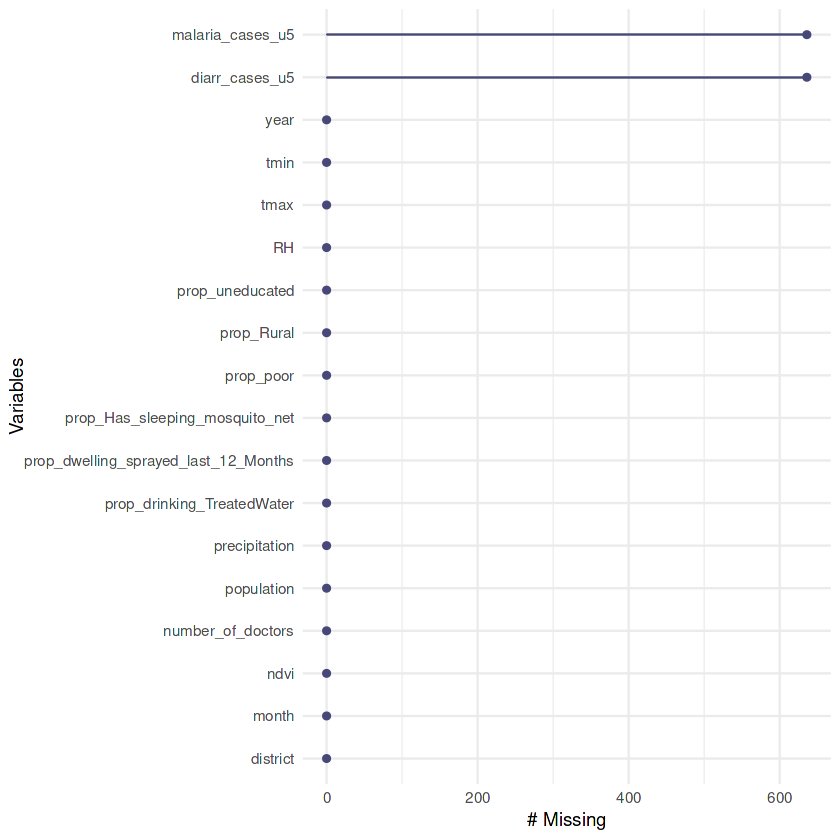

In [679]:
test_data <- test_data%>%
  select(
    district, year, month, malaria_cases_u5, tmin, tmax, precipitation, RH, population,
    ndvi, prop_poor, prop_Rural, prop_drinking_TreatedWater, prop_Has_sleeping_mosquito_net,
    prop_dwelling_sprayed_last_12_Months, prop_uneducated, number_of_doctors, diarr_cases_u5
  ) 
test_data <- test_data %>%
  impute_mean("number_of_doctors") %>%
  impute_mean("ndvi") %>%
impute_mean("tmin") %>%
impute_mean("tmax")
plot <- gg_miss_var(test_data)

# Display the plot
print(plot)


In [713]:
min_max_scale <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}
test_data2<-test_data
test_data2$district<-NULL
test_data2$year<-NULL
test_data2$month<-NULL
test_data2$diarr_cases_u5<-NULL
# # Apply scaling to the entire dataset (assuming it's numeric)
scaled_data_test <- as.data.frame(lapply(test_data2, min_max_scale))

In [714]:
# Load the trained model from the file
loaded_xgb_model <- xgb.load("xgb_model.model")


In [715]:
# Convert the test data to DMatrix format
test_matrix <- xgb.DMatrix(
  data = as.matrix(scaled_data_test %>% select(-malaria_cases_u5))
)

# Predict on the test data using the loaded model
xgb_test_predictions_malaria <- predict(loaded_xgb_model, newdata = test_matrix)
# xgb_test_predictions
# # Apply inverse scaling if needed
# xgb_test_predictions <- inverse_transform(xgb_test_predictions, test_data$malaria_cases_u5)



# # Create dataframe with actual vs predicted values for test data
results_df_xgb_test <- data.frame(
  # Actual = test_actual,
  Predicted = xgb_test_predictions_malaria
  # Difference = test_actual - xgb_test_predictions
)

# Display first few rows of the results
head(results_df_xgb_test)


,Predicted
,<dbl>
1,4302.604
2,5481.936
3,3747.801
4,3317.743
5,2637.628
6,2530.443


In [712]:
# Load the trained model from the file
loaded_xgb_model_diarr <- xgb.load("xgb_model_diarr.model")

min_max_scale <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}
test_data3<-test_data
test_data3$district<-NULL
test_data3$year<-NULL
test_data3$month<-NULL
test_data3$malaria_cases_u5<-NULL
# # Apply scaling to the entire dataset (assuming it's numeric)
scaled_data_test <- as.data.frame(lapply(test_data3, min_max_scale))
# Convert the test data to DMatrix format (excluding diarrhea cases)
test_matrix_diarr <- xgb.DMatrix(
  data = as.matrix(scaled_data_test %>% select(-diarr_cases_u5))
)

# Predict on the test data using the loaded model for diarrhea
xgb_test_predictions_diarr <- predict(loaded_xgb_model_diarr, newdata = test_matrix_diarr)

# Create a dataframe with predicted values for diarrhea cases
results_df_xgb_test_diarr <- data.frame(
  Predicted = xgb_test_predictions_diarr
)

# Display first few rows of the results
head(results_df_xgb_test_diarr)


,Predicted
,<dbl>
1,239.9488
2,169.2056
3,148.4079
4,150.3215
5,173.4133
6,154.5298


In [717]:
# Define the required columns
group_name <- rep("Group_8", length(xgb_test_predictions_malaria))  # Replace "Group_1" with your actual group name
year <- test_data$year  # Ensure this column exists in your validation dataset
month <- test_data$month  # Ensure this column exists
district_id <- test_dataa$ID # Ensure this column exists

# Create a dataframe with the required format
submission_df <- data.frame(
  Group_name = group_name,
  Year = year,
  Month = month,
  District_ID = district_id,
  Malaria_prediction = xgb_test_predictions_malaria,
  Diarrheal_prediction = xgb_test_predictions_diarr
)

# Save as CSV
write.csv(submission_df, "submission_file.csv", row.names = FALSE)

print("Submission file saved as 'submission_file.csv'")


[1] "Submission file saved as 'submission_file.csv'"
